In [19]:
# Enabling auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from pprint import pp

import pandas as pd

# You need to import custom class for loading pickle file to work.
from classes_v1 import DataHandler, MyEval, MyUtil, RegSwitcher

In [21]:
IS_PLOT = False
SAVE_PLOT = False

### Load data

In [22]:
# Search for pkl files
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir(".") if (isfile(join(".", f)) and f.endswith("pkl"))]
pp(onlyfiles)

['S04_data_2025-05-16_21-47.pkl', 'S04_data_2025-05-16_22-02.pkl']


In [23]:
filename = "S04_data_2025-05-16_22-02.pkl"
data_load = MyUtil.load_data(filename=filename)

# Print keys
pp([k for k in data_load.keys()])


['desc', 'data_handler', 'param_split', 'param_grid_hyper', 'df_fit']


In [24]:
dt = MyUtil.get_dt()

In [25]:
data_handler = data_load["data_handler"]
df_fit = data_load["df_fit"]

In [26]:
df_fit

,id_split,param_split,id_gs,params,estimator,mean_test_score,std_test_score,rank_test_score,validation_scores
0,0,"{'random_state': 1, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,LinearRegression,-2.372222,3.924419,7,"[0.0381745359446262, 0.7520240440765592, -7.90..."
1,0,"{'random_state': 1, 'test_size': 0.3}",1,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,-0.006503,0.027330,6,"[-0.0022755109373579683, -0.04188876497945082,..."
2,0,"{'random_state': 1, 'test_size': 0.3}",2,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.304896,0.003312,5,"[0.302294515805052, 0.3095696294549572, 0.3028..."
3,0,"{'random_state': 1, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.744229,0.089645,4,"[0.6177065038720949, 0.8144446900525925, 0.800..."
4,0,"{'random_state': 1, 'test_size': 0.3}",4,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.747307,0.069475,3,"[0.7218386879359913, 0.8422226024451405, 0.677..."
5,0,"{'random_state': 1, 'test_size': 0.3}",5,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.776209,0.051304,1,"[0.7370470074905021, 0.8486849829614732, 0.742..."
6,0,"{'random_state': 1, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.771796,0.061343,2,"[0.7345456330474859, 0.8582725266854542, 0.722..."
7,1,"{'random_state': 2, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,LinearRegression,-1.937197,3.212609,7,"[-0.13937271441371277, 0.777359375151465, -6.4..."
8,1,"{'random_state': 2, 'test_size': 0.3}",1,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.011377,0.037278,6,"[0.042289212343515126, 0.032905918683216906, -..."
9,1,"{'random_state': 2, 'test_size': 0.3}",2,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.304724,0.042627,5,"[0.3280930724834618, 0.3411633989478616, 0.244..."


### Calculate test results

In [27]:
# Sort the DataFrame by "rank_test_score"
df_fit = df_fit.sort_values(by="rank_test_score")

# Groups the sorted DataFrame by the columns "id_split" and "estimator".
# For each group (unique combination of split and estimator), selects the first row (which, after sorting, is the one with the best rank_test_score).
# .reset_index() turns the groupby indices back into columns for a clean DataFrame.
df_fit_select = df_fit.groupby(["id_split", "estimator"]).first().reset_index()

display(df_fit_select)

,id_split,estimator,param_split,id_gs,params,mean_test_score,std_test_score,rank_test_score,validation_scores
0,0,LinearRegression,"{'random_state': 1, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-2.372222,3.924419,7,"[0.0381745359446262, 0.7520240440765592, -7.90..."
1,0,RandomForestRegressor,"{'random_state': 1, 'test_size': 0.3}",5,{'base': MultiOutputRegressor(estimator=Random...,0.776209,0.051304,1,"[0.7370470074905021, 0.8486849829614732, 0.742..."
2,0,SVR,"{'random_state': 1, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,0.744229,0.089645,4,"[0.6177065038720949, 0.8144446900525925, 0.800..."
3,1,LinearRegression,"{'random_state': 2, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-1.937197,3.212609,7,"[-0.13937271441371277, 0.777359375151465, -6.4..."
4,1,RandomForestRegressor,"{'random_state': 2, 'test_size': 0.3}",4,{'base': MultiOutputRegressor(estimator=Random...,0.757133,0.094545,1,"[0.6340905043019229, 0.8639696063021075, 0.773..."
5,1,SVR,"{'random_state': 2, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,0.703175,0.050213,4,"[0.7117799983754173, 0.7599177723301004, 0.637..."
6,2,LinearRegression,"{'random_state': 3, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-6.095767,8.482891,7,"[-0.947498514280532, 0.7141621891195524, -18.0..."
7,2,RandomForestRegressor,"{'random_state': 3, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,0.736916,0.066827,2,"[0.7668161883748071, 0.6443240277245796, 0.799..."
8,2,SVR,"{'random_state': 3, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,0.753062,0.044288,1,"[0.7612869455812917, 0.8027208605802253, 0.695..."
9,3,LinearRegression,"{'random_state': 4, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-4.400783,7.369193,7,"[-14.821434516944576, 0.9321352673466916, 0.68..."


In [28]:
# Initialize blank model (optional)
reg = RegSwitcher(base=None)


df_arr = []
for idx, fit in df_fit_select.iterrows():
    # pp(fit["param_split"])
    # pp(fit["params"])

    param_split = fit["param_split"]
    data_handler.split_and_scale(**param_split)

    X_train, Y_train = data_handler.get_train()
    X_test, Y_test = data_handler.get_test()

    params = fit["params"]
    reg.set_params(**params)

    reg.fit(X_train, Y_train)

    Y_train_pred = reg.predict(X_train)
    Y_test_pred = reg.predict(X_test)

    _df = MyEval.eval(
        Y_train=Y_train,
        Y_train_pred=Y_train_pred,
        Y_test=Y_test,
        Y_test_pred=Y_test_pred,
        id_split=fit["id_split"],
        id_gs=fit["id_gs"],
        estimator=fit["estimator"],
    )
    df_arr.append(_df)

    if IS_PLOT:
        id_split = fit["id_split"]
        estimator = fit["estimator"]
        MyEval.plot_res(
            Y_train=Y_train,
            Y_train_pred=Y_train_pred,
            Y_test=Y_test,
            Y_test_pred=Y_test_pred,
            dt=dt,
            save=SAVE_PLOT,
            file_prefix=f"S05-{estimator}-{id_split}",
        )

df_eval = pd.concat(df_arr).reset_index(drop=True)

In [29]:
df_eval

,id_split,id_gs,estimator,Y,MSE Train (No Val),MSE Test,MAPE Train (No Val),MAPE Test,R2 Train,R2 Test
0,0,0,LinearRegression,Y-1,9.907720e-08,6.684604e-07,0.000673,0.001180,1.000000,0.999999
1,0,0,LinearRegression,Y-2,2.599749e-03,5.520998e-02,0.451948,0.373733,0.997400,0.930653
2,0,0,LinearRegression,Y-3,6.233074e-08,4.205366e-07,0.002542,0.002603,1.000000,0.999999
3,0,0,LinearRegression,Y-All,8.666367e-04,1.840369e-02,0.151721,0.125839,0.999133,0.976884
4,0,5,RandomForestRegressor,Y-1,2.350936e-02,1.484970e-01,0.405711,0.398001,0.976491,0.834392
5,0,5,RandomForestRegressor,Y-2,2.529971e-02,1.092540e-01,0.718033,3.643333,0.974700,0.862771
6,0,5,RandomForestRegressor,Y-3,1.452682e-02,7.373701e-02,7.235421,0.853025,0.985473,0.884414
7,0,5,RandomForestRegressor,Y-All,2.111196e-02,1.104960e-01,2.786388,1.631453,0.978888,0.860526
8,0,3,SVR,Y-1,2.696358e-02,1.542565e-01,0.298181,0.276762,0.973036,0.827969
9,0,3,SVR,Y-2,4.879577e-02,8.426635e-02,1.086893,1.233234,0.951204,0.894157


### Visualize results

<Axes: xlabel='estimator', ylabel='MSE Test'>

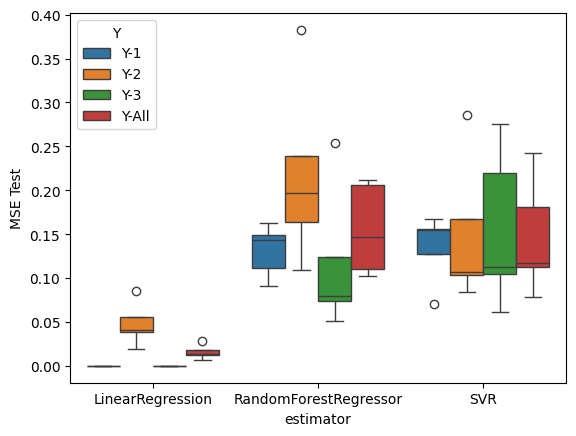

In [30]:
import seaborn as sns

sns.boxplot(data=df_eval, x="estimator", y="MSE Test", hue="Y")

<Axes: xlabel='estimator', ylabel='R2 Test'>

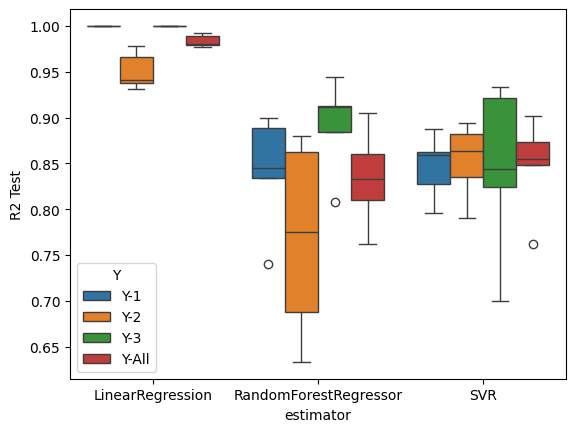

In [31]:
sns.boxplot(data=df_eval, x="estimator", y="R2 Test", hue="Y")